# Worksheet 16

Name: Ziye Chen  
UID: U98411098 

### Topics

- Support Vector Machines (Non-linear case)

## Support Vector Machines

Follow along in class to implement the perceptron algorithm and create an animation of the algorithm.

a) As we saw in class, the form
$$w^T x + b = 0$$
while simple, does not expose the inner product `<x_i, x_j>` which we know `w` depends on, having done the math. This is critical to applying the "kernel trick" which allows for learning non-linear decision boundaries. Let's modify the above algorithm to use the form
$$\sum_i \alpha_i <x_i, x> + b = 0$$

In [1]:
import numpy as np
from PIL import Image as im
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

TEMPFILE = "temp.png"
CENTERS = [[0, 1], [1, 0]]

epochs = 100
learning_rate = .05
expanding_rate = .99
retracting_rate = 1.1

X, labels = datasets.make_blobs(n_samples=10, centers=CENTERS, cluster_std=0.2, random_state=0)
Y = np.array(list(map(lambda x : -1 if x == 0 else 1, labels.tolist())))

alpha_i = np.zeros((len(X),))
b = 0

def snap(x, alpha_i, b, error):
    # create a mesh to plot in
    h = .01  # step size in the mesh
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    meshData = np.c_[xx.ravel(), yy.ravel()]
    cs = np.array([x for x in 'gb'])
    fig, ax = plt.subplots()
    ax.scatter(X[:,0],X[:,1],color=cs[labels].tolist(), s=50, alpha=0.8)

    if error:
        ax.add_patch(plt.Circle((x[0], x[1]), .12, color='r',fill=False))
    else:
        ax.add_patch(plt.Circle((x[0], x[1]), .12, color='y',fill=False))
   
    Z = predict_many(alpha_i, b, meshData)
    Z = np.array([0 if z <=0 else 1 for z in Z]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=.5, cmap=plt.cm.Paired)
    fig.savefig(TEMPFILE)
    plt.close()
    return im.fromarray(np.asarray(im.open(TEMPFILE)))

def predict_many(alpha_i, b, Z):
    res = []
    for i in range(len(Z)):
        res.append(predict(alpha_i, b, Z[i]))
    return np.array(res)

def predict(alpha_i, b, x):
    wx = np.sum(alpha_i * Y * np.dot(X, x))
    return wx + b

images = []
for _ in range(epochs):
    # pick a point from X at random
    i = np.random.randint(0, len(X))
    error = False
    x, y = X[i], Y[i]
    
    ypred = predict(alpha_i, b, x)
    
    if ypred * y > 0:
        # correct
        if abs(ypred) < 1:
            # margin is too wide
            alpha_i[i] += y * learning_rate
            alpha_i *= retracting_rate
            b += y * learning_rate * retracting_rate
        else:
            # margin is too narrow
            alpha_i *= expanding_rate
            b *= expanding_rate
    else:
        # wrong
        alpha_i[i] += y * learning_rate
        alpha_i *= expanding_rate
        b += y * learning_rate * expanding_rate
        
    images.append(snap(x, alpha_i, b, error))

images[0].save(
    'svm_dual.gif',
    optimize=False,
    save_all=True,
    append_images=images[1:],
    loop=0,
    duration=100
)


Write a configurable kernel function to apply in lieu of the dot product. Try it out on a dataset that is not linearly separable.

In [4]:
def polynomial(x_i, x_j, c, n):
    return (np.dot(x_i, x_j) + c) ** n

In [3]:
import numpy as np
from PIL import Image as im
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

TEMPFILE = "temp.png"
CENTERS = [[0, 1], [1, 0]]

epochs = 100
learning_rate = .05
expanding_rate = .99
retracting_rate = 1.1

X, labels = datasets.make_blobs(n_samples=100, centers=CENTERS, cluster_std=0.6, random_state=0)
Y = np.array(list(map(lambda x: -1 if x == 0 else 1, labels.tolist())))

alpha_i = np.zeros((len(X),))
b = 0

def polynomial(x_i, x_j, c=1, n=3):
    return (np.dot(x_i, x_j) + c) ** n

def snap(x, alpha_i, b, error):
    h = .01
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    meshData = np.c_[xx.ravel(), yy.ravel()]
    cs = np.array([x for x in 'gb'])
    fig, ax = plt.subplots()
    ax.scatter(X[:, 0], X[:, 1], color=cs[labels].tolist(), s=50, alpha=0.8)

    if error:
        ax.add_patch(plt.Circle((x[0], x[1]), .12, color='r', fill=False))
    else:
        ax.add_patch(plt.Circle((x[0], x[1]), .12, color='y', fill=False))

    Z = predict_many(alpha_i, b, meshData)
    Z = np.array([0 if z <= 0 else 1 for z in Z]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=.5, cmap=plt.cm.Paired)
    fig.savefig(TEMPFILE)
    plt.close()
    return im.fromarray(np.asarray(im.open(TEMPFILE)))

def predict_many(alpha_i, b, Z):
    return np.array([predict(alpha_i, b, z) for z in Z])

def predict(alpha_i, b, x):
    return np.sum(alpha_i * Y * np.array([polynomial(x_i, x) for x_i in X])) + b

images = []
for _ in range(epochs):
    i = np.random.randint(0, len(X))
    error = False
    x, y = X[i], Y[i]
    
    ypred = predict(alpha_i, b, x)
    error = ypred * y <= 0

    if not error:
        if abs(ypred) < 1:
            alpha_i[i] += y * learning_rate
            alpha_i *= retracting_rate
            b += y * learning_rate * retracting_rate
        else:
            alpha_i *= expanding_rate
            b *= expanding_rate
    else:
        alpha_i[i] += y * learning_rate
        alpha_i *= expanding_rate
        b += y * learning_rate * expanding_rate
        
    images.append(snap(x, alpha_i, b, error))

images[0].save(
    'svm_dual_polynomial.gif',
    optimize=False,
    save_all=True,
    append_images=images[1:],
    loop=0,
    duration=100
)


b) Assume we fit an SVM using a polynomial Kernel function and it seems to overfit the data. How would you adjust the tuning parameter `n` of the kernel function?

the parameter n which is the degree of the polynomial, controls that complexity of the model. Is the model is overfitting, I would lower the parameter n to get less complext decision boundary

c) Assume we fit an SVM using a RBF Kernel function and it seems to underfit the data. How would you adjust the tuning parameter `sigma` of the kernel function?

Given that the model is too simple, sigma controls the width of the width of a kernel. Having a bigger sigma increases the flexibility and capture the complex data and prevent it from underfitting

d) Tune the parameter of a specific Kernel function, to fit an SVM (using your code above) to the following dataset:

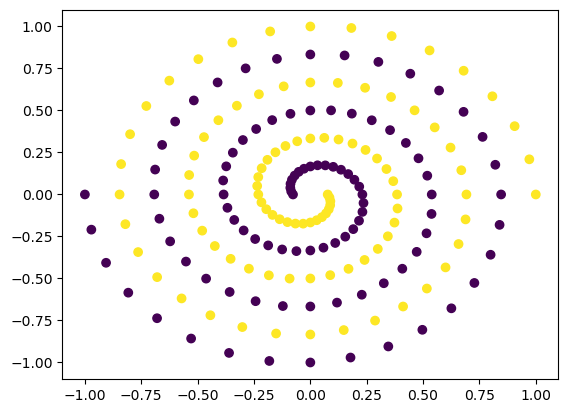

In [7]:
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt("spiral.data")
x, y = data[:, :2], data[:, 2]

plt.scatter(x[:,0], x[:,1], c=y)

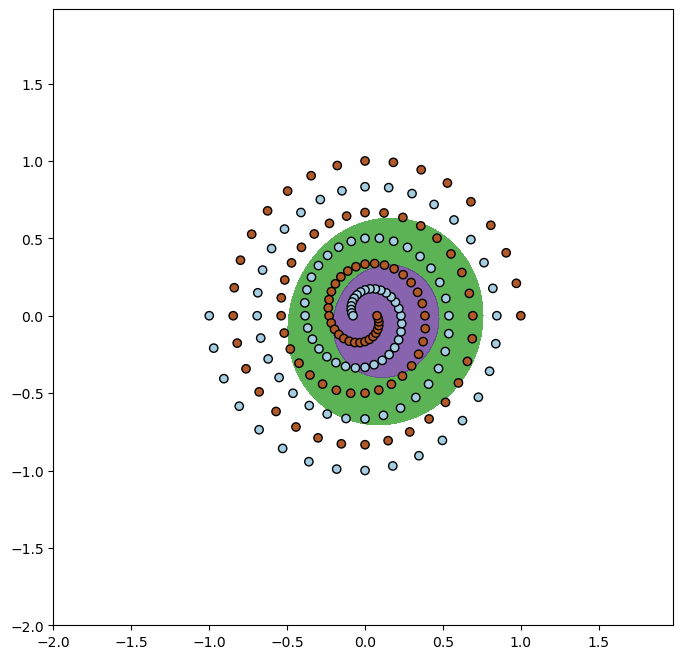

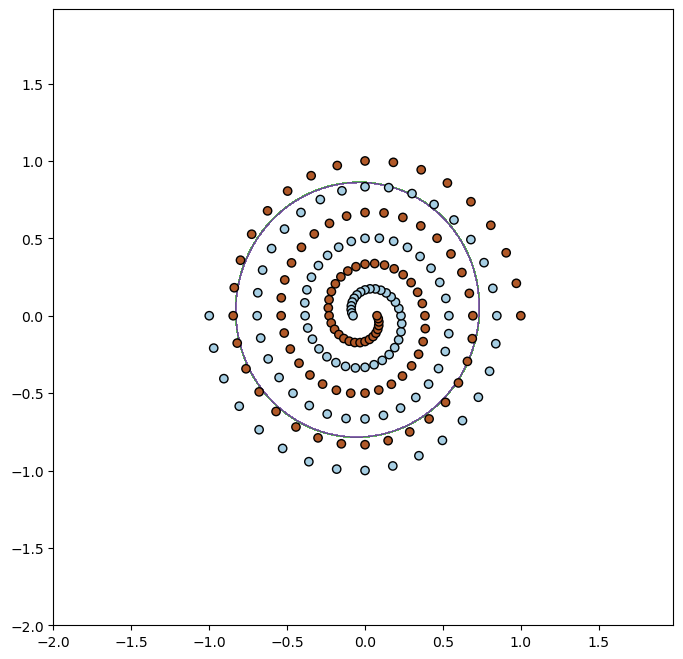

In [11]:
import matplotlib.pyplot as plt

# SVM parameters
epochs = 100
learning_rate = 0.1
expanding_rate = 0.99
retracting_rate = 1.1
gamma = 1.0  # RBF kernel hyperparameter

# Initialize variables
alpha_i = np.zeros(len(x))
b = 0

def rbf_kernel(x_i, x_j, gamma):
    return np.exp(-gamma * np.linalg.norm(x_i - x_j) ** 2)

def predict(alpha_i, b, x_point, gamma):
    return np.sum(alpha_i * y * np.array([rbf_kernel(x_i, x_point, gamma) for x_i in x])) + b

def snap(x_point, alpha_i, b, gamma):
    h = .02
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = np.array([predict(alpha_i, b, np.array([xx_point, yy_point]), gamma)
                  for xx_point, yy_point in zip(np.ravel(xx), np.ravel(yy))])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, alpha=0.8, levels=[-1, 0, 1], cmap=plt.cm.Paired)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    plt.pause(0.1)  # Pause to show the plots dynamically

# Training the SVM with the RBF kernel
for epoch in range(epochs):
    for i in range(len(x)):
        x_point, y_point = x[i], y[i]
        y_pred = predict(alpha_i, b, x_point, gamma)

        if y_pred * y_point <= 0:
            alpha_i[i] += y_point * learning_rate
            b += y_point * learning_rate

    if epoch % 50 == 0:
        snap(x[0], alpha_i, b, gamma)  # Visualize the decision boundary

plt.show()

